In [1]:
from backend.data.DataSetManager import DataSetManager
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
# Use Cuda GPU if available to speed up process, else just use the CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# Check device used
device

'cpu'

# Move data to raw data directory, transform, and load data

In [3]:
# Load the brain MRI dataset using Kaggle's API
dataset = DataSetManager()
# Download and move the dataset to 'backend/data/raw/brain_tumor_mri_dataset' if not already downloaded and moved
dataset.download_and_move_dataset()
# Transform data and split to train, validation, and testing sets
train_dataset, test_dataset, train_loader, val_loader, test_loader = dataset.load_data()

Dataset already exists at: ../data/raw/brain_tumor_mri_dataset/. Skipping download.


# Visualization

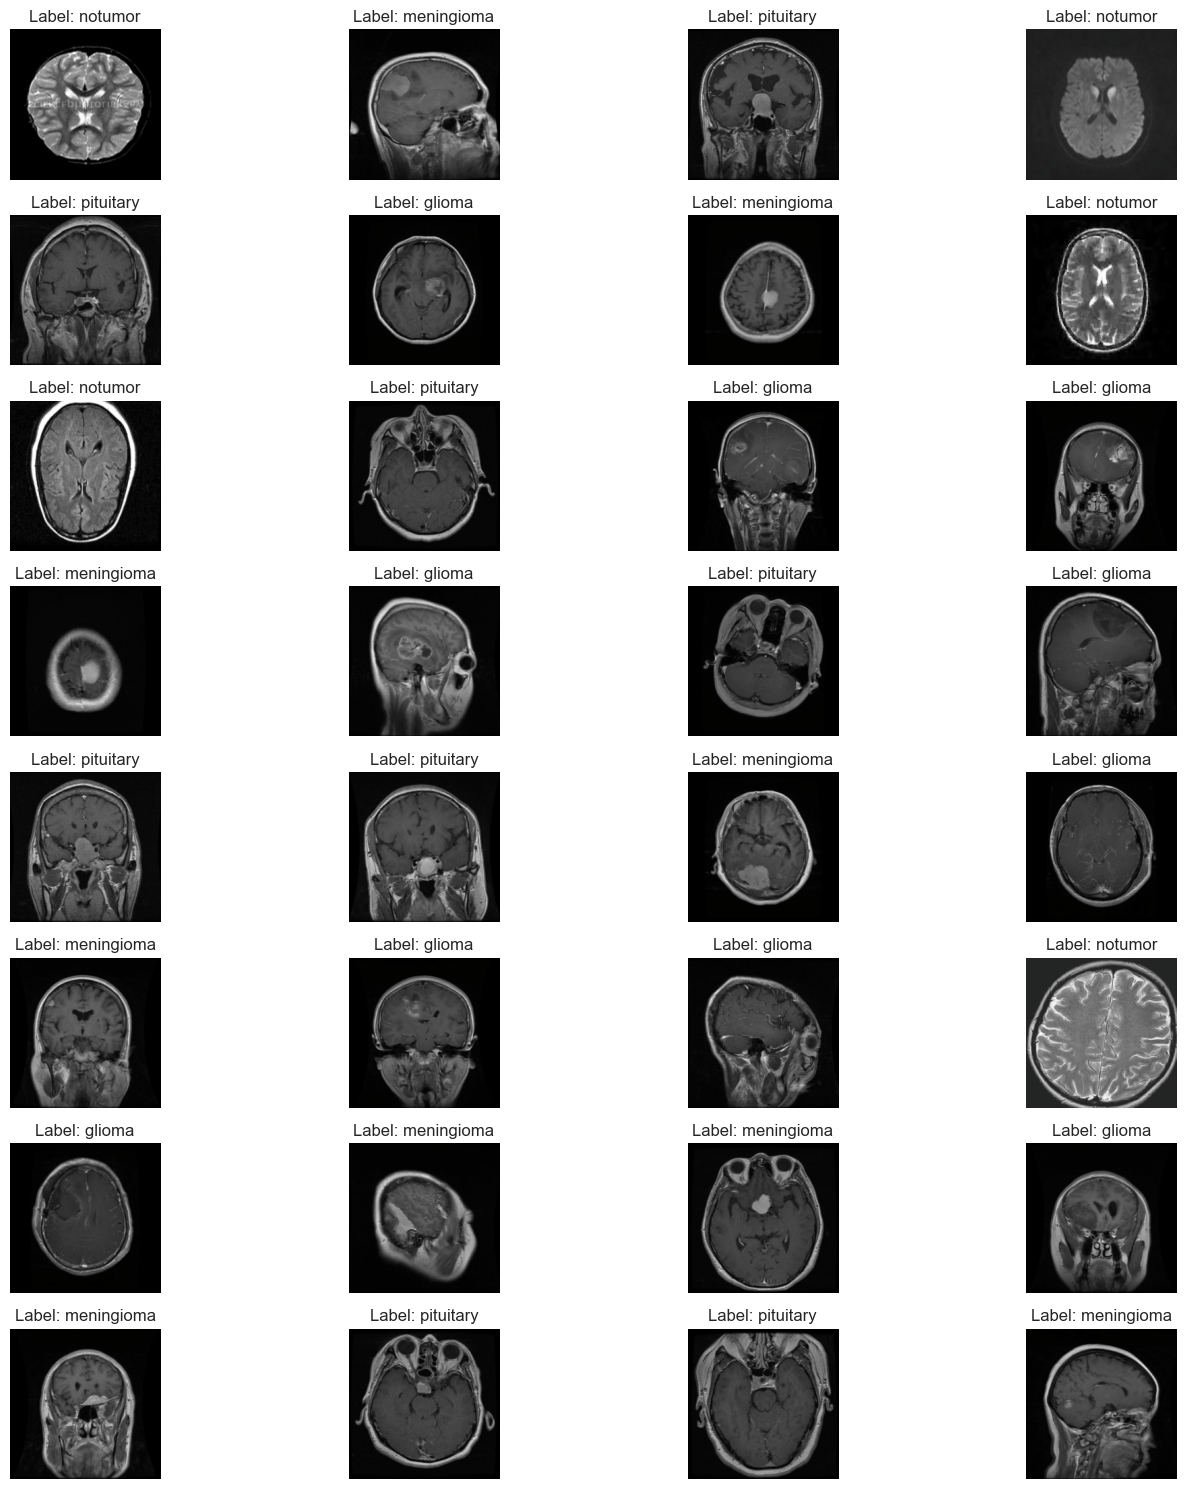

In [4]:
# Iterate through training dataset 
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

# Denormalize the images (since we did normalization during the transformation of the raw images)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# Change image format to support Matplotlib, denormalize, and clip pixel values b/w [0,1]
images = (images.numpy().transpose((0,2,3,1)) * std + mean).clip(0,1)

# Create a grid of images
num_images_in_batch = len(images)
rows = int(np.ceil(num_images_in_batch / 4))
# Create a figure (rows * 4) = (8 * 4)
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images_in_batch:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(8*8*128, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Train model and validate on validation set

In [6]:
cnn_model = BrainTumorClassifier(4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [7]:
def train_model():
    """
    Trains the CNN
    :return: Avg. loss and accuracy of the model
    """
    cnn_model.train()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    for batch_number, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        
        loss.backward()
        optimizer.step()
        
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [8]:
def eval_model():
    """
    Evaluates the CNN on the validation set
    :return: Avg. loss and avg. accuracy of the evaluation
    """
    cnn_model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_number, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions 
    
    return avg_loss, avg_accuracy

In [9]:
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

best_val_score = float('inf')
num_epochs = 40

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    avg_train_loss, train_accuracy = train_model()
    avg_val_loss, val_accuracy = eval_model()
    
    if avg_val_loss < best_val_score:
        best_val_score = avg_val_loss
        torch.save(cnn_model.state_dict(), f'../models/best_model.pth')
        
        
    all_train_losses.append(avg_train_loss)
    all_train_accuracies.append(train_accuracy)
    all_val_losses.append(avg_val_loss)
    all_val_accuracies.append(val_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_val_loss:.4f}, Eval Accuracy: {val_accuracy * 100:.2f}%")
    print("-" * 90)

Epoch 1/40
Train Loss: 0.7262, Train Accuracy: 74.31%
Eval Loss: 0.5448, Eval Accuracy: 80.58%
------------------------------------------------------------------------------------------
Epoch 2/40
Train Loss: 0.3602, Train Accuracy: 86.61%
Eval Loss: 0.3299, Eval Accuracy: 87.14%
------------------------------------------------------------------------------------------
Epoch 3/40
Train Loss: 0.3086, Train Accuracy: 88.31%
Eval Loss: 0.3828, Eval Accuracy: 86.09%
------------------------------------------------------------------------------------------
Epoch 4/40
Train Loss: 0.2481, Train Accuracy: 90.83%
Eval Loss: 0.3419, Eval Accuracy: 87.05%
------------------------------------------------------------------------------------------
Epoch 5/40
Train Loss: 0.2146, Train Accuracy: 92.27%
Eval Loss: 0.3006, Eval Accuracy: 89.50%
------------------------------------------------------------------------------------------
Epoch 6/40
Train Loss: 0.1729, Train Accuracy: 94.02%
Eval Loss: 0.370

# Visualize training history

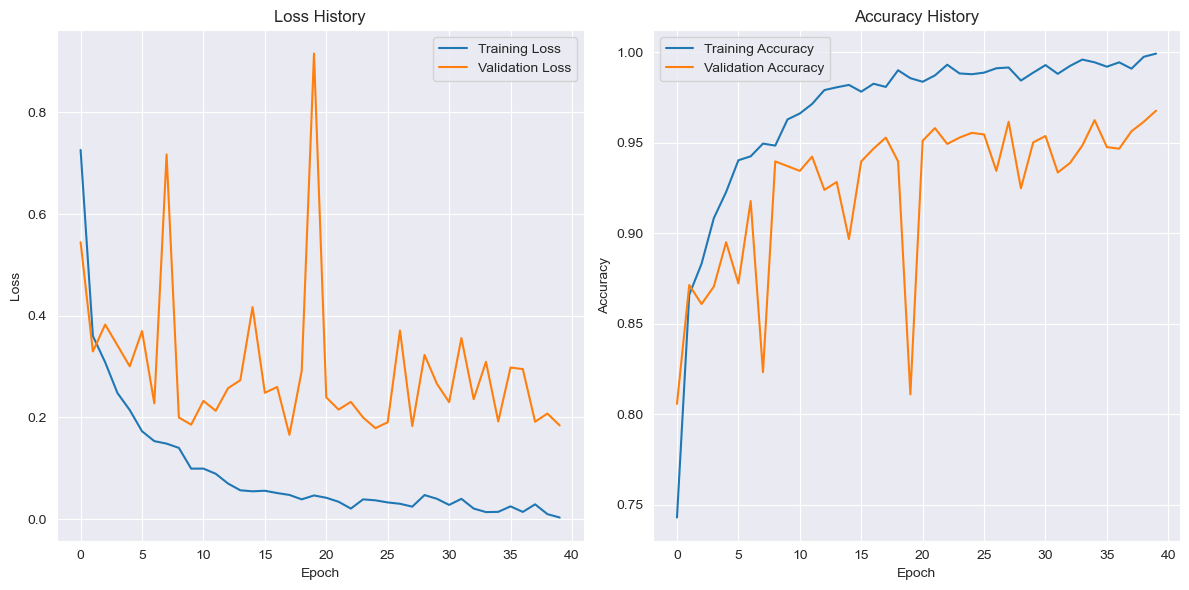

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(all_train_losses, label='Training Loss')
plt.plot(all_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(all_train_accuracies, label='Training Accuracy')
plt.plot(all_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

# Test the best model on the testing set

In [13]:
best_model = BrainTumorClassifier(4).to(device)
best_model.load_state_dict(torch.load('../models/best_model.pth', map_location=device))


# Initialize lists to store all true and predicted labels
all_predictions = []
all_true_labels = []

# Test the model
test_loss = 0.0
correct = 0
total = 0

best_model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = cnn_model(images)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Get predicted labels
        _, predicted = torch.max(outputs, 1)
        
        # Store true and predicted labels
        all_predictions.extend(predicted.cpu().numpy())  # Convert to numpy and store
        all_true_labels.extend(labels.cpu().numpy())     # Convert to numpy and store
        
        # Calculate test accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
test_accuracy = correct / total
average_test_loss = test_loss / len(test_loader)

print(f'Test Loss: {average_test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.2%}')


/var/folders/xj/8mcqn1jn1y90s_ydvgj143lh0000gn/T/ipykernel_60706/2049638310.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('../mod

Test Loss: 0.1832
Test Accuracy: 97.25%


# Confusion Matrix

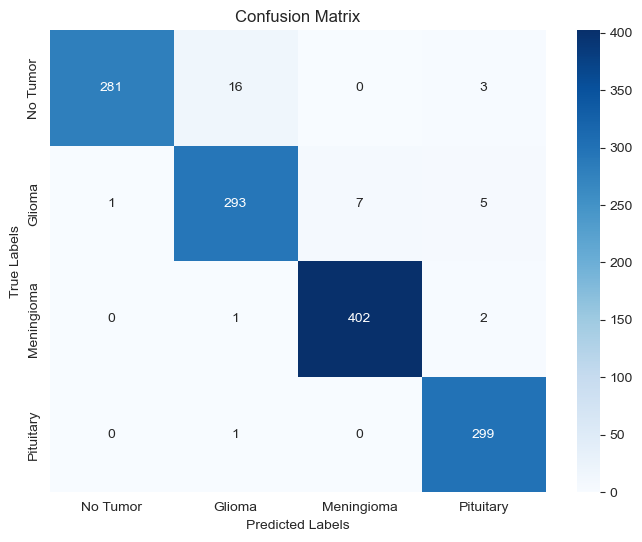

In [12]:
# Compute the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Glioma", "Meningioma", "Pituitary"], 
            yticklabels=["No Tumor", "Glioma", "Meningioma", "Pituitary"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()